In [81]:
#============================ Loading required libraries ============================#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import seaborn
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [82]:
#============================ Loading the dataset ============================#

# Change the path of dataset
df = pd.read_csv('/content/drive/MyDrive/heart_disease_uci.csv')
df = df.rename(columns={'num': 'disease_present'}) # Renaming target column
df = df.drop(['id', 'dataset'], axis=1) # Dropping useless columns

# Mapping values 1,2,3,4 to 1 (disease is present)
# 0 represents that disease is absent
df['disease_present'] = df.disease_present.map({0: 0, 1: 1, 2: 1, 3: 1, 4: 1})

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,disease_present
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


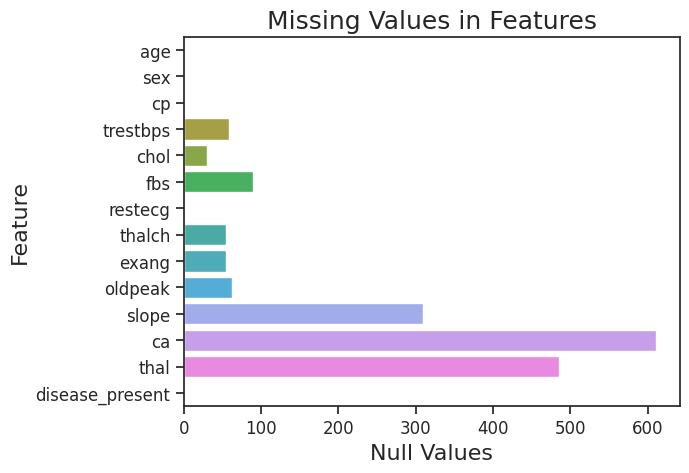

In [83]:
#============================ Missing Value Treatment ============================#

# Counting null values in each feature
df_null = pd.DataFrame(df.isnull().sum().reset_index())
df_null.columns = ['feature', 'null_values']
df_null

# Barchart for null values
sns.barplot(y=df_null['feature'], x=df_null['null_values'], orient='h')
plt.title('Missing Values in Features', fontsize=18)
plt.xlabel('Null Values', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [84]:
# For Categorical features, replacing null values using backfill method
df = df.sample(frac = 1, random_state=0)
df['restecg'].fillna(method='bfill', inplace=True)
df['fbs'].fillna(method='bfill', inplace=True)
df['exang'].fillna(method='bfill', inplace=True)
df['slope'].fillna(method='bfill', inplace=True)
df['thal'].fillna(method='bfill', inplace=True)
df.isnull().sum()

age                  0
sex                  0
cp                   0
trestbps            59
chol                30
fbs                  0
restecg              0
thalch              55
exang                0
oldpeak             62
slope                0
ca                 611
thal                 0
disease_present      0
dtype: int64

In [85]:
# For Numerical features, replacing null values with mean of the feature
df['thalch'] = df['thalch'].fillna(df['thalch'].mean())
df['oldpeak'] = df['oldpeak'].fillna(df['oldpeak'].mean())
df['trestbps'] = df['trestbps'].fillna(df['trestbps'].mean())
df['chol'] = df['chol'].fillna(df['trestbps'].mean())
df['ca'] = df['ca'].fillna(df['ca'].mean())
df.isnull().sum()

age                0
sex                0
cp                 0
trestbps           0
chol               0
fbs                0
restecg            0
thalch             0
exang              0
oldpeak            0
slope              0
ca                 0
thal               0
disease_present    0
dtype: int64

In [86]:
#============================ Visualizations ============================#

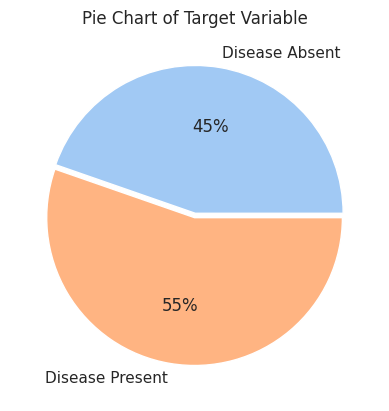

In [87]:
# Pie-chart of Target feature - disease_present

unique_values = df['disease_present'].unique()
counts = df['disease_present'].value_counts().sort_values()
percentages = counts / counts.sum() * 100
plt.pie(percentages, labels=['Disease Absent', 'Disease Present'],
        colors= seaborn.color_palette('pastel'), explode=[0.02,0.01], autopct='%.0f%%')
plt.title('Pie Chart of Target Variable')
plt.show()

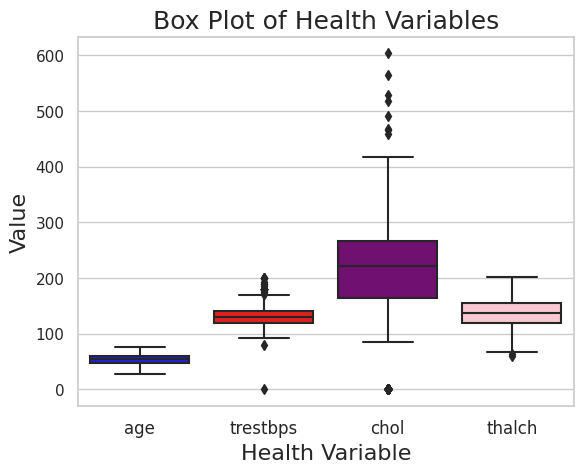

In [88]:
#============================ Box Plot of Health Variables ============================#

# Select variables for box plots
health_variables = ['age', 'trestbps', 'chol', 'thalch']

# Define colors for each variable
colors = ['blue', 'red', 'purple', 'pink']

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a box plot using Seaborn
#plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=df[health_variables], palette=colors)

# Set x-axis ticks and labels with rotation
ax.set_xticks(range(len(health_variables)))
ax.set_xticklabels(health_variables, fontsize=12)

# Set labels and title
ax.set_xlabel('Health Variable', fontsize=16)
ax.set_ylabel('Value', fontsize=16)
ax.set_title('Box Plot of Health Variables', fontsize=18)

plt.show()

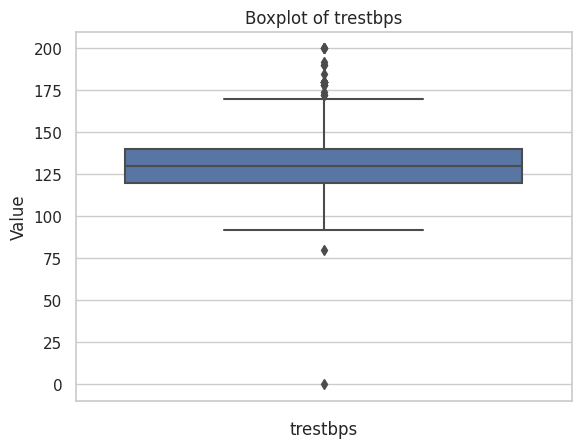

In [89]:
# Boxplot for any numerical feature
numerical_features = ['age', 'trestbps', 'chol', 'fbs', 'exang', 'oldpeak', 'thalch']
feature = 'trestbps'
sns.boxplot( y=df[feature] );
plt.xlabel(feature)
plt.ylabel('Value')
plt.title('Boxplot of {}'.format(feature))
plt.show()

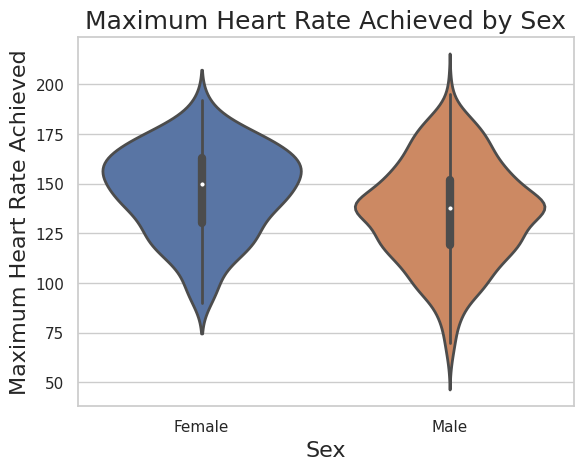

In [90]:
# Violin Plot of Maximum Heart Rate Achieved
import seaborn

# use to set style of background of plot
seaborn.set(style="whitegrid")

ax = seaborn.violinplot(x=df["sex"], y=df["thalch"], linewidth = 2)

ax.set_xlabel('Sex', fontsize=16)
ax.set_ylabel('Maximum Heart Rate Achieved', fontsize=16)
ax.set_title('Maximum Heart Rate Achieved by Sex', fontsize=18)

plt.show()

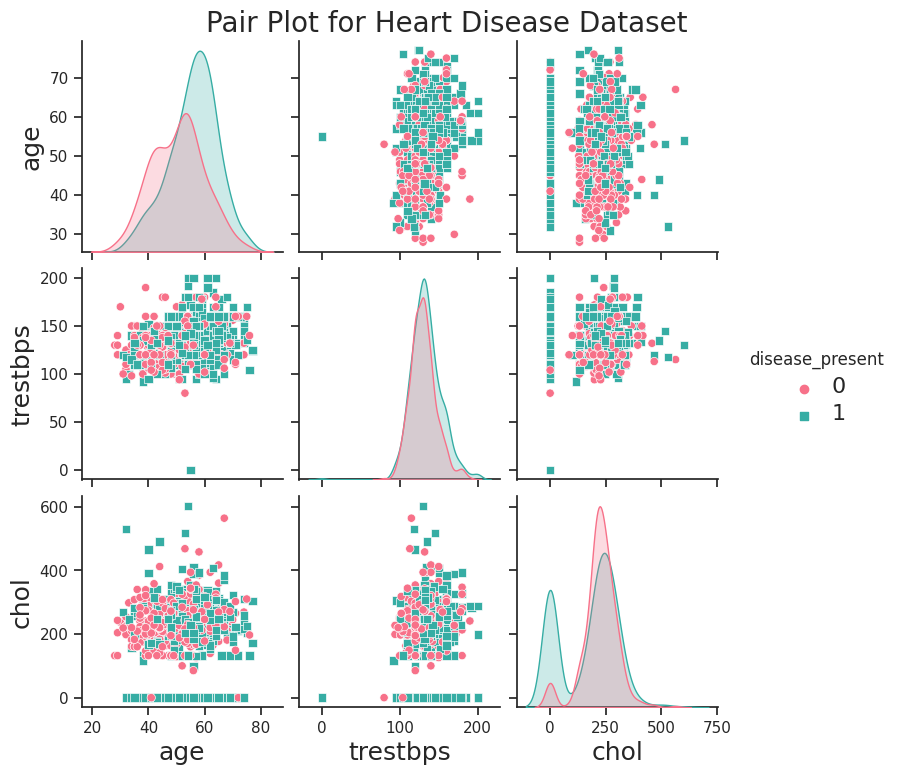

In [91]:
#============================ Pair Plot ============================#

# Select specific columns
selected_columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'disease_present']

# Create a copy of the subset
df_subset = df[selected_columns].copy()

# Convert categorical variables to appropriate data types
df_subset['sex'] = df_subset['sex'].astype('category')
df_subset['cp'] = df_subset['cp'].astype('category')
df_subset['disease_present'] = df_subset['disease_present'].astype('category')

# Create a pair plot for multivariate EDA
sns.set(style="ticks", color_codes=True)
pair_plot = sns.pairplot(df_subset, hue='disease_present', palette='husl', markers=["o", "s"])

# Add a title to the pair plot
pair_plot.fig.suptitle("Pair Plot for Heart Disease Dataset", y=1.02, fontsize=20)

legend = pair_plot._legend
for text in legend.get_texts():
    text.set_fontsize(16)

# Loop through each subplot to set x and y labels
for ax in pair_plot.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=18)  # Increase x-axis label font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)  # Increase y-axis label font size

# Show the plot
plt.show()

In [92]:
#============================ Data Transformation for Modeling ============================#

# Label Encoding for categorical features
label_encoder = LabelEncoder()
df['cp'] = label_encoder.fit_transform(df['cp'])
df['restecg'] = label_encoder.fit_transform(df['restecg'])
df['slope'] = label_encoder.fit_transform(df['slope'])
df['thal'] = label_encoder.fit_transform(df['thal'])
df['fbs'] = label_encoder.fit_transform(df['fbs'])
df['exang'] = label_encoder.fit_transform(df['exang'])

df['sex']=df['sex'].replace(('Male','Female'),(1,0))
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,disease_present
306,30,0,3,170.000000,237.0,0,2,170.000000,0,0.000000,2,0.676375,0,0
711,68,1,0,135.000000,0.0,0,2,120.000000,1,0.000000,2,0.676375,2,1
298,45,1,3,110.000000,264.0,0,1,132.000000,0,1.200000,1,0.000000,2,1
466,55,1,2,120.000000,220.0,0,0,134.000000,0,0.000000,2,0.676375,1,0
253,51,0,2,120.000000,295.0,0,0,157.000000,0,0.600000,2,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,64,1,0,132.132404,306.0,1,2,137.545665,1,0.878788,1,0.676375,2,1
192,43,1,0,132.000000,247.0,1,0,143.000000,1,0.100000,1,0.676375,2,1
629,51,1,0,130.000000,0.0,1,1,170.000000,0,-0.700000,2,0.676375,2,1
559,47,0,2,135.000000,248.0,1,1,170.000000,0,0.000000,1,0.676375,2,1


In [93]:
df.to_csv('/content/drive/MyDrive/final_data.csv', index = False)

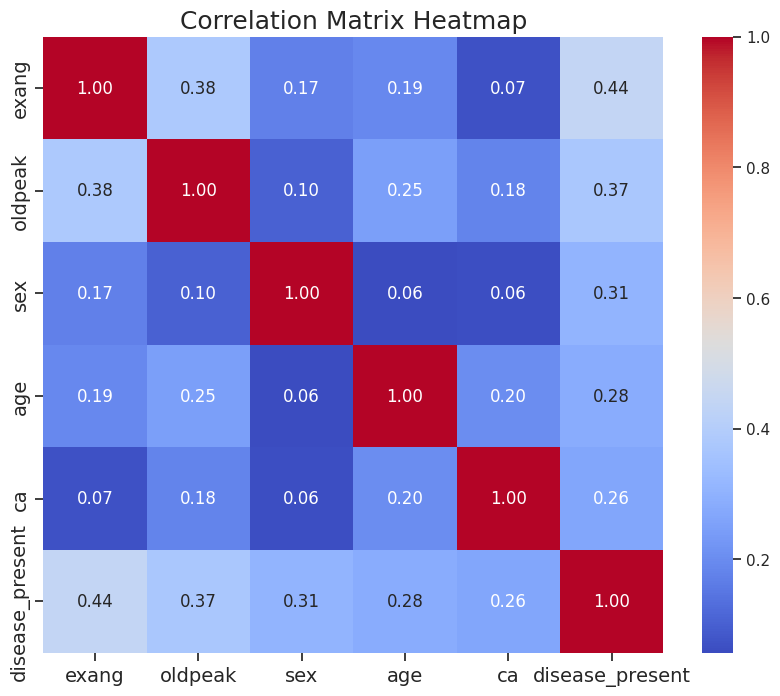

In [94]:
#============================ Correlation Matrix Heatmap ============================#
features_analysis=['exang', 'oldpeak', 'sex', 'age', 'ca', 'disease_present']
# features_analysis=['age', 'sex', 'trestbps', 'oldpeak', 'disease_present']
# features_analysis = df.columns
for i in features_analysis:
    df[i] = pd.to_numeric(df[i], errors='coerce')

subset_data = df[features_analysis]

correlation_matrix = subset_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [95]:
#===============================================================================#
#============================ Classification Models ============================#
#===============================================================================#

In [96]:
#============================ Scaling the data using standard scaler ============================#

In [97]:
df = pd.read_csv('/content/drive/MyDrive/final_data.csv')

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [98]:
#============================ Support Vector Machine (SVM) ============================#


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        73
           1       0.84      0.83      0.84       111

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184

Metrics for Test Set:
Accuracy: 0.8043478260869565


Text(91.25, 0.5, 'Predicted')

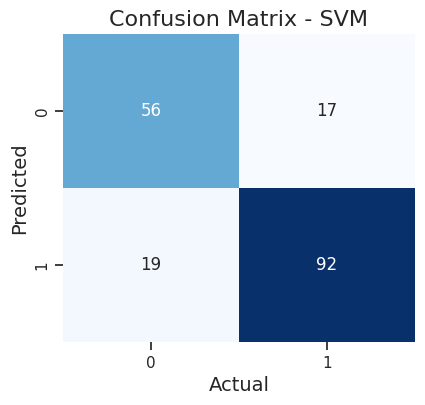

In [99]:
classifier = SVC(kernel='rbf')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

print('Metrics for Test Set:')
print('Accuracy: {}'.format((cm_test[0][0] + cm_test[1][1]) / len(y_test)))

# Plot Confusion Matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - SVM', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)

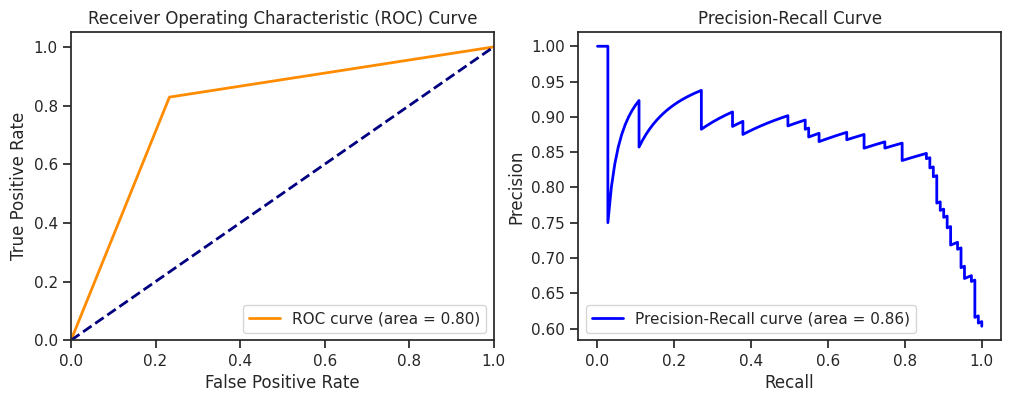

In [100]:
# ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve of test set
precision, recall, thresholds = precision_recall_curve(y_test, classifier.decision_function(X_test))
area_under_curve = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(area_under_curve))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [101]:
#============================ Logistic Regression  ============================#

Accuracy for test set for Logistic Regression = 77.72%

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.77      0.73        73
           1       0.84      0.78      0.81       111

    accuracy                           0.78       184
   macro avg       0.77      0.78      0.77       184
weighted avg       0.78      0.78      0.78       184



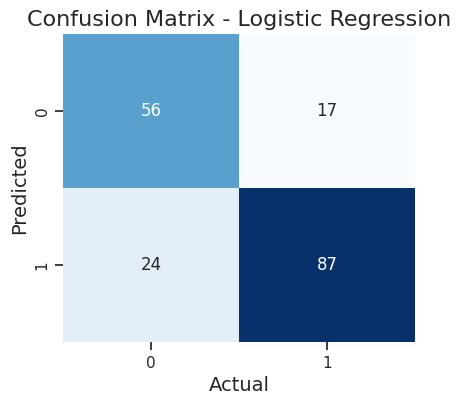

In [102]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# predictions(Test Set)
y_pred = classifier.predict(X_test)

# confusion matrix(Test Set)
cm_test = confusion_matrix(y_test, y_pred)

# predictions(Training Set)
y_pred_train = classifier.predict(X_train)

# confusion matrix(Training Set)
cm_train = confusion_matrix(y_pred_train, y_train)

# print the accuracy
#print('Accuracy for training set for Logistic Regression = {:.2%}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Logistic Regression = {:.2%}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# confusion matrix visualization
#plt.figure(figsize=(12, 4))
#plt.subplot(1, 2, 1)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - Logistic Regression', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)
# # ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.subplot(1, 2, 2)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')

# plt.tight_layout()
# plt.show()

# cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=5)
#print("\nCross-Validation Scores:", cv_scores)
#print("Mean CV Accuracy: {:.2%}".format(cv_scores.mean()))

In [103]:
#============================ XGBoost ============================#

Accuracy for test set for XGBoost = 0.782608695652174

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        73
           1       0.84      0.78      0.81       111

    accuracy                           0.78       184
   macro avg       0.77      0.78      0.78       184
weighted avg       0.79      0.78      0.78       184



Text(91.25, 0.5, 'Predicted')

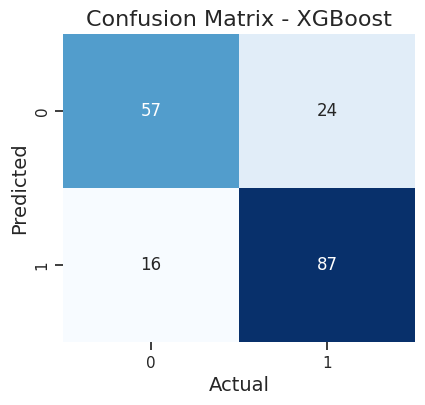

In [104]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

cm_test = confusion_matrix(y_pred, y_test)
#print("confusion matrix for test set", cm_test)
TP = cm_test[1, 1]  # True Positives
FP = cm_test[0, 1]  # False Positives
TN = cm_test[0, 0]  # True Negatives
FN = cm_test[1, 0]  # False Negatives

precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("Accuracy for test set for XGBoost =", (TN + TP)/len(y_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
y_pred_train = xg.predict(X_train)

for i in range(0, len(y_pred_train)):
    if y_pred_train[i]>= 0.5:       # setting threshold to .5
       y_pred_train[i]=1
    else:
       y_pred_train[i]=0
        # Confusion Matrix Plot for Test & Training set
# Plot Confusion Matrices
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost', fontsize = 16)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Predicted', fontsize = 14)

In [105]:
#============================ Visualizations comparing Classification Models ============================#

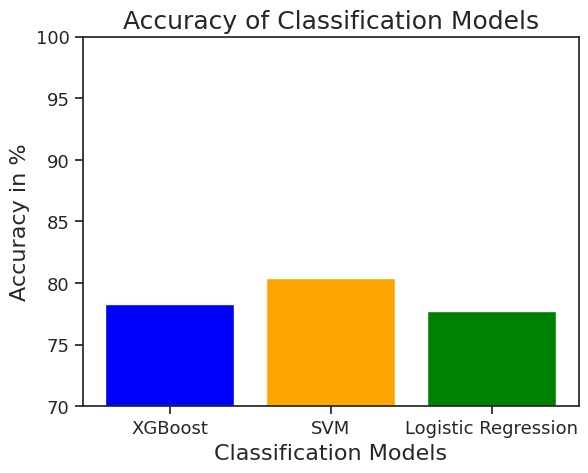

In [106]:
# Bar plot to compare accuracy of classifiers

# Accuracy scores of three models
models = ['XGBoost', 'SVM', 'Logistic Regression']
accuracy = [78.26, 80.43, 77.71]  # Replace these values with your accuracy scores

# Create bar chart
#plt.figure(figsize=(8, 6))
plt.bar(models, accuracy, color=['blue', 'orange', 'green'])

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Accuracy in %', fontsize=16)
plt.title('Accuracy of Classification Models', fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
plt.ylim(70, 100)  # Set the y-axis limits
plt.show()


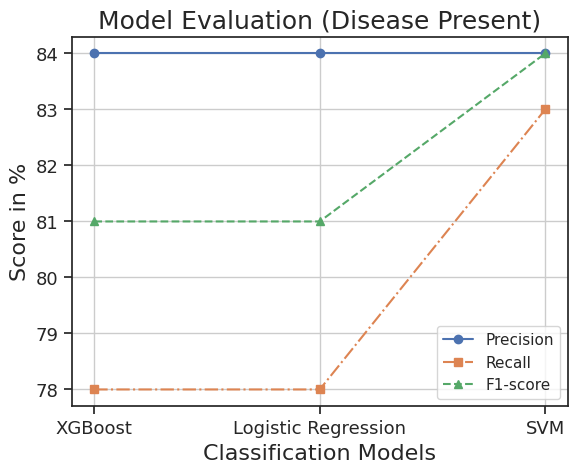

In [107]:
# Line chart to compare precision, recall and f1-score of classifiers (Class 1, Disease present)

# Precision, recall, and F1-scores of three models
models = ['XGBoost', 'Logistic Regression', 'SVM']
precision = [84, 84, 84]
recall = [78, 78, 83]
f1_scores = [81, 81, 84]

# Create line chart for precision
#plt.figure(figsize=(8, 6))
plt.plot(models, precision, marker='o', label='Precision', linestyle='-')

# Add line chart for recall
plt.plot(models, recall, marker='s', label='Recall', linestyle='-.')

# Add line chart for F1-score
plt.plot(models, f1_scores, marker='^', label='F1-score', linestyle='--')

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Score in %', fontsize=16)
plt.title('Model Evaluation (Disease Present)', fontsize=18)
plt.legend()  # Show legend
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
#plt.ylim(0, 1)  # Set the y-axis limits
plt.grid(True)  # Add gridlines
plt.show()


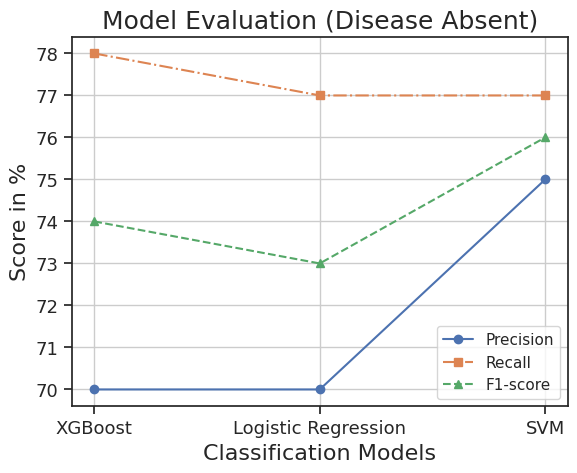

In [108]:
# Line chart to compare precision, recall and f1-score of classifiers (Class 0, Disease absent)

# Precision, recall, and F1-scores of three models
models = ['XGBoost', 'Logistic Regression', 'SVM']
precision = [70, 70, 75]
recall = [78, 77, 77]
f1_scores = [74, 73, 76]

# Create line chart for precision
#plt.figure(figsize=(8, 6))
plt.plot(models, precision, marker='o', label='Precision', linestyle='-')

# Add line chart for recall
plt.plot(models, recall, marker='s', label='Recall', linestyle='-.')

# Add line chart for F1-score
plt.plot(models, f1_scores, marker='^', label='F1-score', linestyle='--')

# Adding labels and title
plt.xlabel('Classification Models', fontsize=16)
plt.ylabel('Score in %', fontsize=16)
plt.title('Model Evaluation (Disease Absent)', fontsize=18)
plt.legend()  # Show legend
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show the plot
#plt.ylim(0, 1)  # Set the y-axis limits
plt.grid(True)  # Add gridlines
plt.show()
